### Segmenting and Clustering Neighbourhoods in Dubai city


<h4>Import necesssary libraries</h4>

In [1]:
import folium
import matplotlib.pyplot as plt
from pandas import json_normalize
import geocoder
import requests
import pandas as pd
import numpy as np
import regex as re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from dotenv import load_dotenv
pd.set_option('display.max_colwidth',None)
print("Libraries imported")

Libraries imported


##  1.Download and Explore Datasets


### 1st Data

I get the data of Dubai Community from a geojason file from Kaggle website since the result from geocoder wasn't accurate 
<a href="https://www.kaggle.com/subhanahsan/dubai-neighborhoods?select=dubai.geojson">Dubai Neighborhoods</a> ,you can simply run a wget command and access the data

In [3]:
!wget -q -O 'dubai.geojson' https://www.kaggle.com/subhanahsan/dubai-neighborhoods?select=dubai.geojson
print('Data downloaded!')

Data downloaded!


In [2]:
import json
with open(r'C:\Users\sadek\Downloads\dubai.geojson\dubai.geojson',encoding="utf8") as f:
    data = json.load(f)

Create  pandas DataFrame from the JSON file using json_normalize and cleaning the DataFrame from unnecessray columns

In [3]:
Dubai_df = json_normalize(data["features"])
Dubai_df.drop(['type'],1,inplace=True)
Dubai_df.columns=[x.split('.')[1] for x in Dubai_df.columns]
Dubai_df.drop(['CNAME_A','COMMUNITY_A','COMMUNITY_E','Population 2018','coordinates','SHAPE_AREA','SHAPE_LEN','type'],1,inplace=True)
Dubai_df.columns=list(map(str.strip,Dubai_df.columns))
Dubai_df.rename(columns={'CNAME_E':'Community','COMM_NUM':'Community Code','Population 2019':'Population'},inplace=True)
Dubai_df.head()

,Community,Community Code,Sector,Population,Area Sq Km,Latitude,Longitude
0,HEFAIR,991,9,0,143.565131,24.693237,55.249140
1,AL QUSAIS IND. SECOND,243,2,8834,1.728331,25.281654,55.393184
2,AL JAFILIYA,323,3,23963,1.669479,25.237635,55.286851
3,JABAL ALI SECOND,592,5,1570,5.059545,25.053979,55.115282
4,WADI AL SAFA 5,648,6,21241,16.318810,25.077814,55.352154


There are 225 Community in Dubai

In [4]:
Dubai_df.shape

(226, 7)

In [5]:
# write a function to use geocoder and avoiding timeout error
def get_coor(place,min_attemp=1,max_attemp=5):
    load_dotenv()
    KEY=os.getenv('LocationIQ_Token')
    address="{}, Dubai, United Arab Emirates".format(place)
    try:
        g = geocoder.locationiq(address,key=KEY)
        g.json["status"]=="OK"
        return g.latlng
    except:
        if min_attemp<max_attemp:
            get_coor(place,min_attemp+1)
        else:
            return np.nan

#### Create a map of Dubai City with Community superimposed on top using folium .

* Use geocoder library to get the latitude and longitude values of Dubai City.

In [6]:
Lan,Lon=get_coor('Dubai')
print(Lan,Lon)  #24.9,25.31

25.2653471 55.2924914


In [7]:
# create map of Dubai using latitude and longitude values
map_dubai = folium.Map(location=[Lan, Lon], zoom_start=12)

# add markers to map
for lat, lng, borough,sec in zip(Dubai_df['Latitude'],Dubai_df['Longitude'],Dubai_df['Community'],Dubai_df['Sector']):
    label = '{}-{}'.format(borough,sec)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dubai)  
    
map_dubai

### 2nd Data:

Finally, I use the coordinates from the previous dataset and **foursquare credentials** through its API and retrieve the popular venues with radius of **750m** along with their details and filter the result to get only the following venues that I will use in clustering:
1. College and University.
2. Shopping mall.
3. Historical site.
4. Coffee shop.
5. Park.
6. Bank
7. Gym

In [17]:
#Assign foursquare credentials
load_dotenv()
Client_Id = os.getenv('CLIENT_ID')
Client_Secret = os.getenv('CLIENT_SECRET')
VERSION = '20180605' # Foursquare API versiona
LIMIT = 500 

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    '''
    return a dataframe with the popluar venues around a given location
    '''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_Id, 
            Client_Secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:   
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except KeyError:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

1. **Use the *getNearbyVenues* function to return a DataFrame with popular venues for each commuinty of Dubai City**

In [19]:
Dubai_venues=getNearbyVenues(Dubai_df['Community'],Dubai_df['Latitude'],Dubai_df['Longitude'])
Dubai_venues.head()

HEFAIR
AL QUSAIS IND. SECOND
AL JAFILIYA
JABAL ALI SECOND
WADI AL SAFA 5
MENA JABAL ALI
AL KHEERAN FIRST
AL MURAQQABAT
SAIH AL SALAM
AL MAHA
AL BARSHA SECOND
AL KHABAISI
SAIH SHUAIB 2
AL QUSAIS SECOND
AL TWAR THIRD
AL HEBIAH FIFTH
MARGAB
REMAH
AL HEBIAH FIRST
AL YALAYIS 4
RAS AL KHOR IND. SECOND
WADI ALSHABAK
WADI AL SAFA 7
AL KHWANEEJ SECOND
AL SAFA FIRST
AL RASHIDIYA
AL QOUZ THIRD
AL QOUZ FIRST
NADD AL SHIBA SECOND
JABAL ALI INDUSTRIAL THIRD
AL QUSAIS THIRD
AL LESAILY
AL BARSHA SOUTH FIRST
AL ROWAIYAH FIRST
AL QUSAIS IND. THIRD
MIRDIF
AL SAFA SECOND
AL TWAR FIRST
AL TWAR SECOND
AL CORNICHE
MUHAISNAH FIRST
LEHBAB FIRST
AL QUSAIS IND. FOURTH
UMM ESELAY
NAIF
LEHBAB SECOND
MANKHOOL
WADI AL SAFA 6
AL MERYAL
AL ROWAIYAH SECOND
AL YALAYIS 2
AL QUSAIS IND. FIRST
AL SAFOUH SECOND
AL YALAYIS 3
GRAYTEESAH
NAKHLAT DEIRA
AL WAJEHA AL BAHRIAH
TRADE CENTER SECOND
AL YALAYIS 5
HOR AL ANZ
MUHAISANAH FIFTH
NADD HESSA
JUMEIRA BAY
AL THANYAH SECOND
AL THANYAH FIRST
SAIH SHUAIB 3
AL HEBIAH SECOND
UMM SUQ

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AL QUSAIS IND. SECOND,25.281654,55.393184,Redbox,25.280465,55.387309,Restaurant
1,AL QUSAIS IND. SECOND,25.281654,55.393184,My Flavours,25.287208,55.391363,Restaurant
2,AL QUSAIS IND. SECOND,25.281654,55.393184,Asian Flavors Restaurant,25.278452,55.385195,Asian Restaurant
3,AL QUSAIS IND. SECOND,25.281654,55.393184,McDonald's (ماكدونالدز),25.283921,55.398842,Fast Food Restaurant
4,AL QUSAIS IND. SECOND,25.281654,55.393184,Baskin Robins باسكن روبنز,25.289728,55.393195,Ice Cream Shop


* **Filter the DataFrame to get the categories of interest  only.**
1. Coffee Shop
2. Historic Site
3. Park
4. Gym

In [70]:
Dubai_venues_filtered=Dubai_venues[(Dubai_venues['Venue Category'].str.contains(('Coffee Shop|Café|Shopping Mall|Cafeteria|Historic Site|Park|Gym'),regex=True,flags=re.I))]

2. **Unite all the categories names that refer to the same category like *Café,Cafeteria and Coffee Shop* under one name
for one hot encoding purpose**

In [71]:
Dubai_venues_filtered['Venue Category'].replace('Café|Cafeteria','Coffee Shop',regex=True,inplace=True)
Dubai_venues_filtered['Venue Category'].replace('Water Park|Theme Park Ride / Attraction|National Park|Theme Park','Park',regex=True,inplace=True)
Dubai_venues_filtered['Venue Category'].replace('Gym / Fitness Center|Gym Pool|Gymnastics Gym|Boxing Gym','Gym',regex=True,inplace=True)

e:\Users\sadek\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [72]:
Dubai_venues_filtered.shape

(1091, 7)

3. **Category like *colleges and Banks* doesn't show up using explore with Foursqure API request so I had to use search instead**

* Write a function to get a spesific venues category for a given location

In [34]:
def getCategoryVenues(Query,names, latitudes, longitudes, radius=1000,LIMIT=500):
    '''
    return a dataframe with a given venues category for a given location
    '''
    
    venues_list=[]
    for que in Query:
        for name, lat, lng in zip(names, latitudes, longitudes):

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
                Client_Id, 
                Client_Secret, 
                VERSION,
                Query,
                lat, 
                lng, 
                radius, 
                LIMIT)
                # make the GET request
            results = requests.get(url).json()["response"]['venues']

                # return only relevant information for each nearby venue
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])


    specific_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    try:
        specific_venues.columns = ['Community', 
                      'Community Latitude', 
                      'Community Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude']
    except ValueError:
        pass
    
    return(specific_venues)

* **search for *Universities and college* in Dubai and return the results as DataFrame**

In [35]:
Query=['University,College']
Universities=getCategoryVenues(Query,Dubai_df['Community'],Dubai_df['Latitude'],Dubai_df['Longitude'])

In [39]:
Universities['Venue Category']='University'
Universities.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AL JAFILIYA,25.237635,55.286851,Knowledge Zone for University Admission Services,25.230100,55.286636,University
1,AL JAFILIYA,25.237635,55.286851,Central Luzon State University,25.225777,55.287170,University
2,AL MURAQQABAT,25.265541,55.323152,University of Dubai (UD) (جامعة دبي),25.258853,55.324191,University
3,AL MURAQQABAT,25.265541,55.323152,University Of Dubai - MBA,25.262019,55.314190,University
4,AL MURAQQABAT,25.265541,55.323152,University of Dubai | Library,25.259234,55.324234,University


* **search for *Banks* in Dubai and return the results as DataFrame**

In [41]:
Query=['Bank']
Banks=getCategoryVenues(Query,Dubai_df['Community'],Dubai_df['Latitude'],Dubai_df['Longitude'])
Banks['Venue Category']='Bank'
Banks.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AL QUSAIS IND. SECOND,25.281654,55.393184,Mashreq Bank بنك المشرق,25.285218,55.389402,Bank
1,AL QUSAIS IND. SECOND,25.281654,55.393184,National Bank Of Abu Dhabi,25.287344,55.391325,Bank
2,AL QUSAIS IND. SECOND,25.281654,55.393184,Commercial bank of Dubai,25.287385,55.400438,Bank
3,AL QUSAIS IND. SECOND,25.281654,55.393184,Al Masraf Bank,25.290427,55.393939,Bank
4,AL QUSAIS IND. SECOND,25.281654,55.393184,national bank of abudhabi qusais branch,25.290902,55.392615,Bank


4. **Join Universities and Banks DataFrame to Dubai_venues_filtered DataFrame**

In [73]:
Dubai_venues_filtered=Dubai_venues_filtered.append(Universities,ignore_index=True)
Dubai_venues_filtered=Dubai_venues_filtered.append(Banks,ignore_index=True)
Dubai_venues_filtered.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AL QUSAIS IND. SECOND,25.281654,55.393184,Tim Hortons,25.282066,55.397946,Coffee Shop
1,AL QUSAIS IND. SECOND,25.281654,55.393184,Madina Mall مدينة مول,25.282042,55.397978,Shopping Mall
2,AL QUSAIS IND. SECOND,25.281654,55.393184,Dino's Café,25.286706,55.390938,Coffee Shop
3,AL QUSAIS IND. SECOND,25.281654,55.393184,Coffee Planet,25.288182,55.391874,Coffee Shop
4,AL QUSAIS IND. SECOND,25.281654,55.393184,Fili,25.277289,55.384537,Coffee Shop


In [74]:
Dubai_venues_filtered.shape

(2224, 7)

##  2.Pre-processing the Dataset


1. preprocessing by using one hot encoding to transform **Venue Category** to a dummies variable

In [75]:
# one hot encoding
Dubai_onehot=pd.get_dummies(Dubai_venues_filtered[['Venue Category']],prefix="",prefix_sep="")
# add Community column back to the begining of the dataframe
Dubai_onehot.insert(0,'Community',Dubai_venues_filtered['Community'])
Dubai_onehot.head()

,Community,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
0,AL QUSAIS IND. SECOND,0,1,0,0,0,0,0
1,AL QUSAIS IND. SECOND,0,0,0,0,0,1,0
2,AL QUSAIS IND. SECOND,0,1,0,0,0,0,0
3,AL QUSAIS IND. SECOND,0,1,0,0,0,0,0
4,AL QUSAIS IND. SECOND,0,1,0,0,0,0,0


2. group rows by Community and taking the mean of the frequency of occurrence of each category

In [105]:
Dubai_grouped=Dubai_onehot.groupby('Community').mean().reset_index()
print(Dubai_grouped.shape)
Dubai_grouped.head()

(139, 8)


,Community,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
0,ABU HAIL,0.333333,0.166667,0.000000,0.0,0.333333,0.000000,0.166667
1,AL BADA',0.277778,0.500000,0.055556,0.0,0.111111,0.000000,0.055556
2,AL BARAHA,0.700000,0.200000,0.000000,0.0,0.100000,0.000000,0.000000
3,AL BARSHA FIRST,0.636364,0.181818,0.090909,0.0,0.000000,0.045455,0.045455
4,AL BARSHA SECOND,0.250000,0.250000,0.000000,0.0,0.375000,0.000000,0.125000


## 3. Clustering using KMeans

1. Using Silhouette Score Elbow Method to detemine the number of clusters

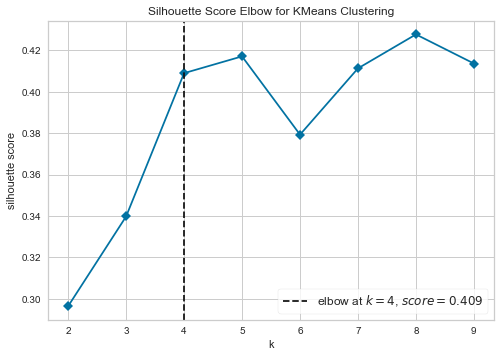

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [106]:
from yellowbrick.cluster import KElbowVisualizer

kclusters = (2,10)

boroughs_grouped_clustering = Dubai_grouped.drop('Community', 1)

# run k-means clustering
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=kclusters, metric='silhouette', timings=False) # random state = 0

visualizer.fit(boroughs_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()       

2. Choosing number of clusters equal to Four and normalize the dataset for better results

In [107]:
X=Dubai_grouped.drop('Community',1)
X=StandardScaler().fit_transform(X)
k_means=KMeans(n_clusters=4,init='k-means++', n_init=10, random_state=0)
k_means.fit(X)
labels = k_means.labels_
labels 

array([0, 2, 0, 0, 3, 2, 0, 3, 2, 3, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2,
       0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 2, 2, 2, 0, 0, 3, 2, 0, 0, 0, 2, 2, 3, 2, 0, 2, 0, 2, 0, 2, 3,
       2, 0, 0, 2, 3, 0, 2, 2, 2, 2, 0, 0, 2, 0, 3, 0, 3, 2, 3, 3, 1, 0,
       0, 0, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2,
       1, 3, 2, 2, 2, 1, 3])

3. Add the Cluster Labels to the datasets 

In [108]:
try:
    Dubai_grouped.insert(1, 'Cluster Labels', k_means.labels_)
except:
    Dubai_grouped.drop('Cluster Labels',1,inplace=True)
    Dubai_grouped.insert(1, 'Cluster Labels', k_means.labels_)
Dubai_grouped

,Community,Cluster Labels,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
0,ABU HAIL,0,0.333333,0.166667,0.000000,0.0,0.333333,0.000000,0.166667
1,AL BADA',2,0.277778,0.500000,0.055556,0.0,0.111111,0.000000,0.055556
2,AL BARAHA,0,0.700000,0.200000,0.000000,0.0,0.100000,0.000000,0.000000
3,AL BARSHA FIRST,0,0.636364,0.181818,0.090909,0.0,0.000000,0.045455,0.045455
4,AL BARSHA SECOND,3,0.250000,0.250000,0.000000,0.0,0.375000,0.000000,0.125000
...,...,...,...,...,...,...,...,...,...
134,WADI AL SAFA 5,2,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
135,WADI AL SAFA 6,2,0.166667,0.500000,0.000000,0.0,0.166667,0.166667,0.000000
136,WARSAN FIRST,2,0.105263,0.789474,0.105263,0.0,0.000000,0.000000,0.000000
137,WARSAN FOURTH,1,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000


4. Write a function to visualise the percentage of each venue category in each cluster as a **Pie chart** 

In [221]:
def cluster_pie(ax,cl_num):
    label= cl_num-1
    title={1:'One',2:'Two',3:'Three',4:'Four',5:'Five'}
    cluster=Dubai_grouped.loc[Dubai_grouped['Cluster Labels'] == label]
    pie=cluster.groupby('Cluster Labels').agg(np.sum).transpose().sort_values(by=label,ascending=False)
    colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'grey','orange']
    explode_list = [0.05, 0.05, 0.05, 0.0, 0.0, 0.0,0.0]
    ax.pie(pie[label],
                                autopct=lambda x:'{}%'.format(round(x,2)) if x!=0 else None, 
                                startangle=30,    
                                shadow=False,       
                                labels=None,         
                                pctdistance=1.22,  
                                colors=colors_list,  
                                explode=explode_list
            )
    ax.set_title('Cluster number {}'.format(title[cl_num]), y=1.15, fontsize=20,fontweight=3) 
    plt.axis('equal')
    ax.legend(labels=pie.index,bbox_to_anchor=(-0.15, .8,0.1,0.1),fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='best')




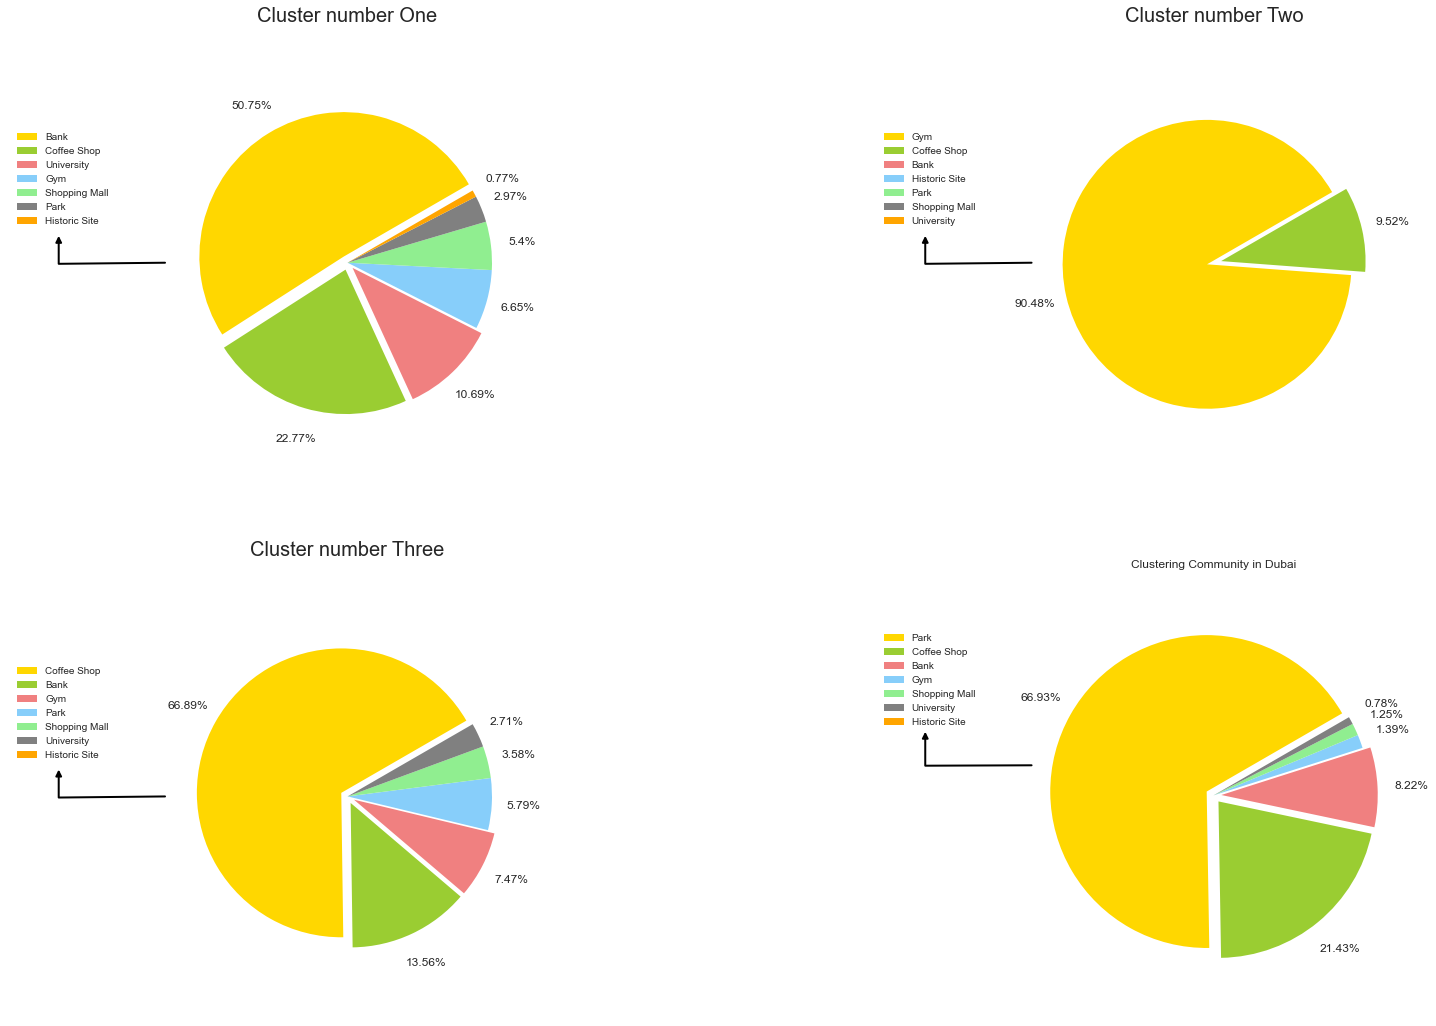

In [217]:
fig = plt.figure(figsize=(22, 18))
ax1=plt.subplot2grid((2,3), (0, 0))
ax2=plt.subplot2grid((2, 3), (0, 2))
ax3=plt.subplot2grid((2, 3), (1, 0))
ax4=plt.subplot2grid((2, 3), (1, 2))
ax1.annotate('',            
             xy=(-.3, .58),  
             xytext=(0, .5),
             xycoords='axes fraction',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc,angleA=0,angleB=-90,armA=0,armB=30,rad=0', color='black', lw=2))
ax2.annotate('',            
             xy=(-.3, .58),  
             xytext=(0, .5),
             xycoords='axes fraction',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc,angleA=0,angleB=-90,armA=0,armB=30,rad=0', color='black', lw=2))
ax3.annotate('',            
             xy=(-.3, .58),  
             xytext=(0, .5),
             xycoords='axes fraction',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc,angleA=0,angleB=-90,armA=0,armB=30,rad=0', color='black', lw=2))
ax4.annotate('',            
             xy=(-.3, .65),  
             xytext=(0, .57),
             xycoords='axes fraction',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc,angleA=0,angleB=-90,armA=0,armB=36,rad=0', color='black', lw=2))
cluster_pie(ax1,1)
cluster_pie(ax2,2)
cluster_pie(ax3,3)
cluster_pie(ax4,4)
plt.title('Clustering Community in Dubai')


plt.savefig('Clustering.png', facecolor='white', transparent=True)



### Visualize each Cluster separately

### Cluster one

In [234]:
cluster_1=Dubai_grouped.loc[Dubai_grouped['Cluster Labels'] == 0]
print(cluster_1.shape)
pd.set_option('display.max_rows', None)
cluster_1

(71, 9)


,Community,Cluster Labels,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
0,ABU HAIL,0,0.333333,0.166667,0.000000,0.000000,0.333333,0.000000,0.166667
2,AL BARAHA,0,0.700000,0.200000,0.000000,0.000000,0.100000,0.000000,0.000000
3,AL BARSHA FIRST,0,0.636364,0.181818,0.090909,0.000000,0.000000,0.045455,0.045455
6,AL BARSHA SOUTH FIRST,0,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
11,AL BUTEEN,0,0.634146,0.219512,0.000000,0.048780,0.000000,0.073171,0.024390
12,AL CORNICHE,0,0.727273,0.000000,0.090909,0.000000,0.000000,0.090909,0.090909
13,AL DAGHAYA,0,0.500000,0.264706,0.029412,0.058824,0.000000,0.117647,0.029412
14,AL GARHOUD,0,0.333333,0.333333,0.125000,0.000000,0.000000,0.000000,0.208333
15,AL HAMRIYA,0,0.704225,0.183099,0.028169,0.028169,0.000000,0.028169,0.028169
22,AL JAFILIYA,0,0.450000,0.350000,0.050000,0.000000,0.050000,0.000000,0.100000


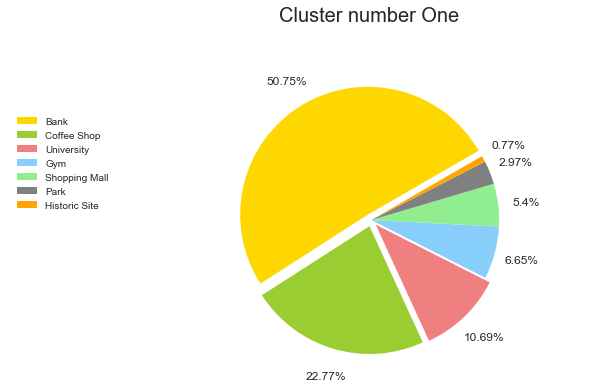

In [222]:
f,ax=plt.subplots(1)
cluster_pie(ax,1)
plt.savefig('Cluster_1.png', facecolor='white', transparent=True)

## Cluster two

In [231]:
cluster_2=Dubai_grouped.loc[Dubai_grouped['Cluster Labels'] == 1]
print(cluster_2.shape)
cluster_2

(7, 9)


,Community,Cluster Labels,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
18,AL HEBIAH FOURTH,1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0
39,AL QOUZ IND.FOURTH,1,0.0,0.333333,0.666667,0.0,0.0,0.0,0.0
64,AL THANYAH FOURTH,1,0.0,0.333333,0.666667,0.0,0.0,0.0,0.0
108,NADD AL SHIBA SECOND,1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0
115,OUD AL MUTEENA THIRD,1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0
132,WADI AL SAFA 3,1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0
137,WARSAN FOURTH,1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0


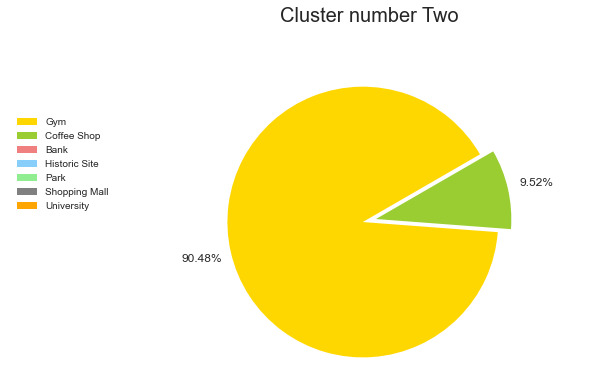

In [224]:
f,ax=plt.subplots(1)
cluster_pie(ax,2)
plt.savefig('Cluster_2.png', facecolor='white', transparent=True)

### Cluster Three

In [229]:
cluster_3=Dubai_grouped.loc[Dubai_grouped['Cluster Labels'] == 2]
print(cluster_3.shape)
cluster_3

(45, 9)


,Community,Cluster Labels,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
1,AL BADA',2,0.277778,0.500000,0.055556,0.0,0.111111,0.000000,0.055556
5,AL BARSHA SOUTH FIFTH,2,0.000000,0.800000,0.000000,0.0,0.200000,0.000000,0.000000
8,AL BARSHA SOUTH SECOND,2,0.000000,0.500000,0.000000,0.0,0.000000,0.250000,0.250000
10,AL BARSHA THIRD,2,0.250000,0.375000,0.250000,0.0,0.000000,0.125000,0.000000
16,AL HAMRIYA PORT,2,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
17,AL HEBIAH FIRST,2,0.062500,0.750000,0.187500,0.0,0.000000,0.000000,0.000000
19,AL HEBIAH SECOND,2,0.000000,0.500000,0.250000,0.0,0.250000,0.000000,0.000000
20,AL HUDAIBA,2,0.300000,0.650000,0.000000,0.0,0.000000,0.000000,0.050000
21,AL JADAF,2,0.250000,0.500000,0.250000,0.0,0.000000,0.000000,0.000000
25,AL KHEERAN,2,0.230769,0.538462,0.076923,0.0,0.076923,0.076923,0.000000


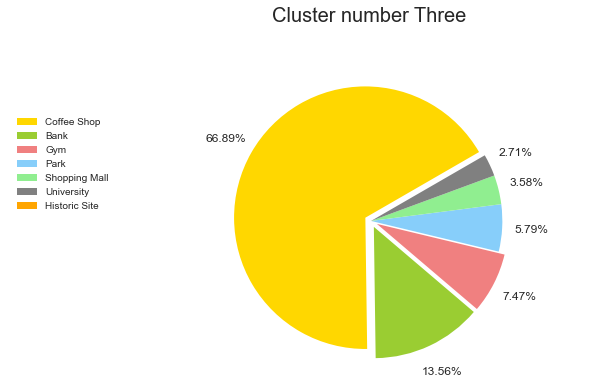

In [226]:
f,ax=plt.subplots(1)
cluster_pie(ax,3)
plt.savefig('Cluster_3.png', facecolor='white', transparent=True)

### Cluster Four

In [230]:
cluster_4=Dubai_grouped.loc[Dubai_grouped['Cluster Labels'] == 3]
print(cluster_4.shape)
cluster_4

(16, 9)


,Community,Cluster Labels,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University
4,AL BARSHA SECOND,3,0.250000,0.250000,0.000000,0.0,0.375000,0.0,0.125
7,AL BARSHA SOUTH FOURTH,3,0.222222,0.000000,0.222222,0.0,0.555556,0.0,0.000
9,AL BARSHA SOUTH THIRD,3,0.000000,0.500000,0.000000,0.0,0.500000,0.0,0.000
49,AL QUSAIS THIRD,3,0.142857,0.428571,0.000000,0.0,0.428571,0.0,0.000
72,AL WARQA'A FIFTH,3,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000
79,AL YALAYIS 2,3,0.000000,0.500000,0.000000,0.0,0.500000,0.0,0.000
87,DUBAI INVESTMENT PARK FIRST,3,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000
92,JABAL ALI FIRST,3,0.250000,0.250000,0.000000,0.0,0.500000,0.0,0.000
102,MUHAISANAH THIRD,3,0.250000,0.250000,0.000000,0.0,0.500000,0.0,0.000
104,MUSHRAIF,3,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000


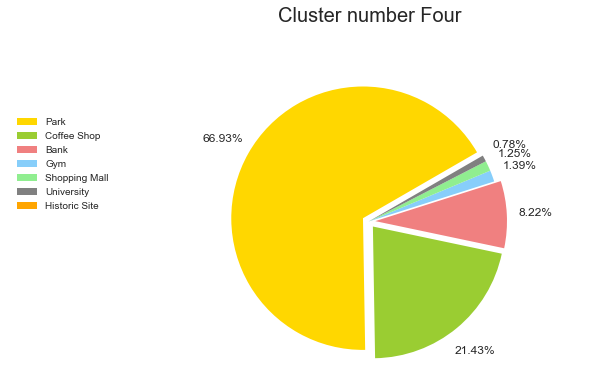

In [228]:
f,ax=plt.subplots(1)
cluster_pie(ax,4)
plt.savefig('Cluster_4.png', facecolor='white', transparent=True)

### Create a map For Dubai show each Community according to its Cluster


In [236]:
Dubai=Dubai_grouped.merge(Dubai_df[['Community','Latitude','Longitude']],how='inner',on='Community')
Dubai

,Community,Cluster Labels,Bank,Coffee Shop,Gym,Historic Site,Park,Shopping Mall,University,Latitude,Longitude
0,ABU HAIL,0,0.333333,0.166667,0.000000,0.000000,0.333333,0.000000,0.166667,25.285437,55.329341
1,AL BADA',2,0.277778,0.500000,0.055556,0.000000,0.111111,0.000000,0.055556,25.225314,55.268768
2,AL BARAHA,0,0.700000,0.200000,0.000000,0.000000,0.100000,0.000000,0.000000,25.281168,55.319549
3,AL BARSHA FIRST,0,0.636364,0.181818,0.090909,0.000000,0.000000,0.045455,0.045455,25.111031,55.194978
4,AL BARSHA SECOND,3,0.250000,0.250000,0.000000,0.000000,0.375000,0.000000,0.125000,25.100854,55.214970
5,AL BARSHA SOUTH FIFTH,2,0.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,25.044857,55.186688
6,AL BARSHA SOUTH FIRST,0,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,25.086661,55.230959
7,AL BARSHA SOUTH FOURTH,3,0.222222,0.000000,0.222222,0.000000,0.555556,0.000000,0.000000,25.058397,55.208846
8,AL BARSHA SOUTH SECOND,2,0.000000,0.500000,0.000000,0.000000,0.000000,0.250000,0.250000,25.072947,55.233786
9,AL BARSHA SOUTH THIRD,3,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,25.060672,55.236512


In [199]:
# create map of Dubai City using latitude and longitude values
map_clusters = folium.Map(location=[Lan, Lon], zoom_start=10)
# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1,len(set(k_means.labels_))))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, poi, cluster in zip(Dubai['Latitude'], Dubai['Longitude'],Dubai['Community'],Dubai['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters